In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2

import torchvision
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import tensorflow as tf

2023-04-20 16:31:39.807563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 16:31:40.618919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
torch.cuda.set_device(1)
device = torch.cuda.current_device()

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.jpg')
        image = read_image(img_path)/255.
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
idrid_train = CustomImageDataset(csv_file='IDRiD/train.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/a. Training Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.RandomHorizontalFlip(p=0.5),
                                                           transforms.RandomVerticalFlip(p=0.3),
                                                           transforms.ColorJitter(brightness=0.1,
                                                                                  contrast=0.1,
                                                                                  saturation=0.01,
                                                                                  hue=0.01),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512)),
                                                           
                                                          ])
                            )
idrid_val = CustomImageDataset(csv_file='IDRiD/val.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/a. Training Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )
idrid_test = CustomImageDataset(csv_file='IDRiD/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv',
                             img_dir='IDRiD/B. Disease Grading/1. Original Images/b. Testing Set',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           
                                                           transforms.Resize((512,512))
                                                          ])
                            )

In [5]:
batch_size=32
train_dataloader = DataLoader(idrid_train, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(idrid_val, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(idrid_test, batch_size=batch_size, shuffle=True)

# MODEL DEFINITION

In [6]:
nSamples = [107, 16, 109, 59, 39]
norm_weights = [1 - (x / sum(nSamples)) for x in nSamples]
model_weights = torch.tensor(norm_weights)

In [19]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

class TransferInceptionV3(nn.Module):
    def __init__(self, num_classes=5, dropout=0.5):
        super(TransferInceptionV3, self).__init__()
        self.features = models.inception_v3(pretrained=True)
        self.features.aux_logits = False 
        for param in self.features.parameters():
            param.requires_grad = True
        self.fc1 = nn.Linear(1000, 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(p=dropout)
        self.leaky_relu = nn.LeakyReLU(inplace=True)
        
    def forward(self, x):
        x = self.features(x)
        #x = x.logits
        #x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.dropout(self.leaky_relu(self.fc1(x)))
        x = self.dropout(self.leaky_relu(self.fc2(x)))
        x = self.fc3(x)
        return x


model = TransferInceptionV3()
model.load_state_dict(torch.load('eyepacs_results/w_32/w_32_eyepacs_last.pt')['model_state_dict'])
model = model.to(torch.cuda.current_device())

#Weighted
criterion = nn.CrossEntropyLoss(weight=model_weights.to(torch.cuda.current_device()))
optimizer = optim.Adam([*model.fc1.parameters(), *model.fc2.parameters()], lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mainuser/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
import timeit
# Train the model
num_epochs = 30

best_val_loss = float('inf')
All_train_loss = []
All_val_loss = []

for epoch in range(num_epochs):
    start_time = timeit.default_timer()
    
    # Train the model on the training set
    total_train_loss = 0
    model.train()
    _batch = 0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        #take argmax of the logits before computing the loss?
        outputs = model(images)
        #logits = outputs.logits
        loss = criterion(outputs, labels)
        total_train_loss += loss * images.shape[0]
        _batch += 1
        if _batch % 10 == 0:
            with open('eyepacs_results/finetune_run_log.txt', 'a') as logfile:
                logfile.write(f"{_batch}: {loss}\n")
            print(f"{_batch}: {loss}")
        # Backward and optimize
        loss.backward()
        optimizer.step()
    
    # Evaluate the model on the validation set
    print(f"---| VALIDATING EPOCH #{epoch+1} |---")
    with open('eyepacs_results/finetune_run_log.txt', 'a') as logfile:
        logfile.write(f"---| VALIDATING EPOCH #{epoch+1} |---\n")
    model.eval()
    with torch.no_grad():
        total_val_loss = 0.0
        correct = 0
        total = 0
        _batch = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            #logits = outputs.logits
            #take argmax of the logits before computing the loss 
            #outputs = outputs.softmax(dim=1)
            val_loss = criterion(outputs, labels)
            _batch += 1
            if _batch % 3 == 0:
                with open('eyepacs_results/finetune_run_log.txt', 'a') as logfile:
                    logfile.write(f"{_batch}: {val_loss}\n")
                print(f"{_batch}: {val_loss}")
            total_val_loss += val_loss.item() * images.shape[0]
            #take argmax of the logits before computing the loss 
            predicted = torch.argmax(outputs, 1) #did torch.argmax instead of torch.max
            total += labels.size(0)
            correct += (predicted == labels).sum()
    avg_train_loss = total_train_loss/330
    avg_val_loss = total_val_loss/83
    print()
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
    with open('eyepacs_results/finetune_run_log.txt', 'a') as logfile:
        logfile.write(f"\nEpoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}\n")
    All_train_loss.append(avg_train_loss.cpu())
    All_val_loss.append(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        print("---| SAVING CHECKPOINT TO DISK |---")
        with open('eyepacs_results/finetune_run_log.txt', 'a') as logfile:
            logfile.write("---| SAVING CHECKPOINT TO DISK |---\n")
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'eyepacs_results/finetune_best.pt')
    
    elapsed = timeit.default_timer() - start_time
    print("Epoch took", str(elapsed//60), "minutes")
    print("---------------------------------------------------------------")
    with open('eyepacs_results/finetune_run_log.txt', 'a') as logfile:
        logfile.write("Epoch took " + str(elapsed//60) + " minutes\n")
        logfile.write("---------------------------------------------------------------\n")

torch.save(model.state_dict(), 'eyepacs_results/finetune_last.pt')

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


10: 1.2078934907913208
---| VALIDATING EPOCH #1 |---
3: 1.015573263168335

Epoch 1/30: Train Loss = 1.0364, Val Loss = 0.8621
Epoch took 6.0 minutes
---------------------------------------------------------------
10: 0.8775981068611145
---| VALIDATING EPOCH #2 |---
3: 0.7323205471038818

Epoch 2/30: Train Loss = 0.9880, Val Loss = 0.8718
Epoch took 6.0 minutes
---------------------------------------------------------------
10: 1.2029534578323364
---| VALIDATING EPOCH #3 |---
3: 0.8474206924438477

Epoch 3/30: Train Loss = 1.0326, Val Loss = 0.8518
---| SAVING CHECKPOINT TO DISK |---
Epoch took 6.0 minutes
---------------------------------------------------------------
10: 0.9780533909797668
---| VALIDATING EPOCH #4 |---
3: 1.020444393157959

Epoch 4/30: Train Loss = 0.9891, Val Loss = 0.8440
---| SAVING CHECKPOINT TO DISK |---
Epoch took 6.0 minutes
---------------------------------------------------------------
10: 0.9736467599868774
---| VALIDATING EPOCH #5 |---
3: 0.7724855542182922

In [29]:
NAll_train_loss = []
for x in All_train_loss:
    NAll_train_loss.append(x.detach().numpy() if isinstance(x, torch.Tensor) else x)

NAll_val_loss = np.array(All_val_loss)
np.savetxt("eyepacs_results/eyepacs_idrid_finetune_adam_train_loss.txt", NAll_train_loss)
np.savetxt("eyepacs_results/eyepacs_idrid_finetune_adam_val_loss.txt", NAll_val_loss)

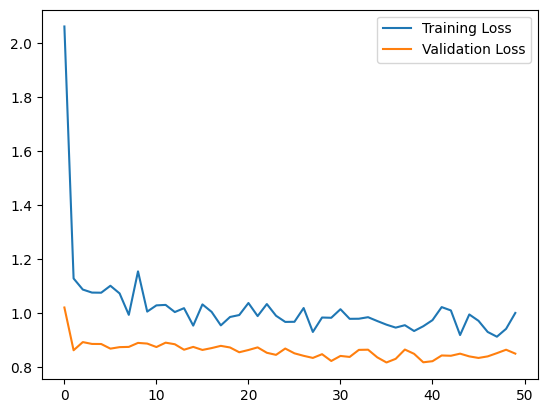

In [30]:
plt.plot(NAll_train_loss, label='Training Loss')
plt.plot(NAll_val_loss,label='Validation Loss')
plt.legend()
plt.show
plt.savefig('eyepacs_results/eyepacs_idrid_finetune_adam_trainLossValLoss.png')

In [31]:
### Testing             
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

#model = TransferInceptionV3()
#model.load_state_dict(torch.load('idrid_best_adam.pt'))
#model = model.to(torch.cuda.current_device())

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu())
        y_pred.extend(predicted.cpu())

# Compute the accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
kappa = cohen_kappa_score(y_true, y_pred)

In [32]:
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'kappa score: {kappa:4f}')

Test Accuracy: 0.5631
Test F1 Score: 0.5377
kappa score: 0.405006


In [33]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[32  0  1  1  0]
 [ 3  1  1  0  0]
 [10  1 11 10  0]
 [ 2  0  2  9  6]
 [ 2  0  2  4  5]]
              precision    recall  f1-score   support

           0      0.653     0.941     0.771        34
           1      0.500     0.200     0.286         5
           2      0.647     0.344     0.449        32
           3      0.375     0.474     0.419        19
           4      0.455     0.385     0.417        13

    accuracy                          0.563       103
   macro avg      0.526     0.469     0.468       103
weighted avg      0.567     0.563     0.538       103



## Evaluation on EyePACS

In [44]:
class EyePACSImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+'.jpeg')
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [45]:
eyePACS_test = EyePACSImageDataset(csv_file='EyePACS/test.csv',
                             img_dir='EyePACS/eyepacs_preprocess/eyepacs_preprocess',
                             transform=transforms.Compose([transforms.ToPILImage(),
                                                           transforms.ToTensor(),
                                                           transforms.Normalize(mean=[0.411,0.285,0.202],
                                                                               std=[0.495,0.349,0.261]),
                                                           transforms.Resize((512,512))
                                                          ])
                            )

In [46]:
eyepacs_test_dataloader = DataLoader(eyePACS_test, batch_size=128, shuffle=True)

In [47]:
model.load_state_dict(torch.load('eyepacs_results/finetune_2_50/finetune_best.pt'))

<All keys matched successfully>

In [48]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    e_y_true = []
    e_y_pred = []
    for images, labels in eyepacs_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs, 1)
        e_y_true.extend(labels.cpu())
        e_y_pred.extend(predicted.cpu())

# Compute the accuracy and F1 score
accuracy = accuracy_score(e_y_true, e_y_pred)
f1 = f1_score(e_y_true, e_y_pred, average='weighted')
kappa = cohen_kappa_score(e_y_true, e_y_pred)

/home/mainuser/.local/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [49]:
print(f'Test Accuracy: {accuracy:.4f}')
print(f'Test F1 Score: {f1:.4f}')
print(f'kappa score: {kappa:4f}')

Test Accuracy: 0.0202
Test F1 Score: 0.0008
kappa score: -0.000001


In [42]:
from sklearn import metrics
# Print the confusion matrix
print(metrics.confusion_matrix(e_y_true, e_y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(e_y_true, e_y_pred, digits=3))

[[26  0  8  0  0]
 [ 3  0  2  0  0]
 [ 7  1 19  5  0]
 [ 2  0  5  7  5]
 [ 2  0  4  4  3]]
              precision    recall  f1-score   support

           0      0.650     0.765     0.703        34
           1      0.000     0.000     0.000         5
           2      0.500     0.594     0.543        32
           3      0.438     0.368     0.400        19
           4      0.375     0.231     0.286        13

    accuracy                          0.534       103
   macro avg      0.392     0.392     0.386       103
weighted avg      0.498     0.534     0.510       103

